This notebook generates sparse matrices for use with `SENSE_matrices.ipynb`. It is a modified version of `SENSE_python.ipynb`.

In [1]:
from __future__ import division
    
%pylab inline

import os
from forbiddenfruit import curse
curse(np.ndarray,'H',property(fget=lambda A: A.T.conj()))

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat, mmwrite, mmread
from scipy.sparse import coo_matrix, dok_matrix, diags
from scipy.special import iv as besseli

def fftc(img):
    return ifftshift(fftn(fftshift(img)))

def ifftc(ksp):
    return fftshift(ifftn(ifftshift(ksp)))
    
# get data from http://hansenms.github.io/sunrise/sunrise2013/
HANSEN = loadmat("../ismrm_sunrise_parallel/hansen_exercises.mat")
locals().update(HANSEN)
who(HANSEN)

# weights
wmtx = diags( w_spiral.flat )
mmwrite("weight.mtx", wmtx)

# sensitivity maps
for i in range(8):
    csm = smaps[:,:,i]
    mmwrite("csm%d.mtx" % i, diags(csm.flat))
    mmwrite("csm%d_conj.mtx" % i, diags(csm.conj().flat))    

# FFT Shifts http://dsp.stackexchange.com/questions/9039/centering-zero-frequency-for-discrete-fourier-transform
checkerboard = np.ones((512,512), dtype=np.float32)
checkerboard[::2,::2] = checkerboard[1::2, 1::2] = -1
mmwrite("fftshift.mtx", diags(checkerboard.flat))
mmwrite("ifftshift.mtx", diags(checkerboard.flat)) # same for even-length signals

Name              Shape               Bytes            Type

smaps             256 x 256 x 8       8388608          complex128
sp                256 x 256           65536            uint8
w_spiral          18176 x 1           145408           float64
data_spiral       18176 x 8           2326528          complex128
noise_color       256 x 256 x 8       8388608          complex128
k_spiral          18176 x 2           290816           float64
noise_spiral      18176 x 8           2326528          complex128
data              256 x 256 x 8       8388608          complex128
reg_img           256 x 256           524288           float64

Upper bound on total bytes  =       30844928


In [3]:
def NuFFT(image_src, coils, k_traj, w, n, osf, wg):    
    # pad image with zeros to the oversampling size
    pw = pad_width = int( n*(osf-1)/2 )
    image = pad(image_src, ([pw,pw], [pw,pw], [0,0]), 'constant' )
    
    # pad matrix
    src_img = image_src[:,:,0]
    dst_img = image[:,:,0]
    P = dok_matrix((dst_img.size, src_img.size))
    for src_coords in ndindex(*src_img.shape):
        dst_coords = np.array(src_coords) + pw
        src_idx = np.ravel_multi_index(src_coords, src_img.shape)
        dst_idx = np.ravel_multi_index(dst_coords, dst_img.shape)
        P[dst_idx, src_idx] = 1.0
    mmwrite("pad.mtx", P)

    # Kernel computation 
    kw = wg / osf
    kosf = floor(0.91 / (osf*1e-3))
    kwidth = osf*kw / 2
    beta = pi*sqrt((kw*(osf-0.5))**2-0.8)

    # compute kernel
    om = arange( floor(kosf*kwidth)+1 ) / floor(kosf*kwidth)
    p = besseli(0, beta*sqrt(1-om*om))
    p /= p[0]
    p[-1] = 0

    # deapodize
    x = arange(-osf*n/2, osf*n/2, dtype=complex) / n
    sqa = sqrt(pi*pi * kw*kw * x*x - beta*beta)
    dax = sin(sqa) / sqa
    dax /= dax[ int(osf*n/2) ]
    da = outer(dax.H, dax)
    image /= da[:,:,newaxis]
    mmwrite("preapodize.mtx", diags((1.0/da).flat))
    
    m = np.zeros((len(k_traj), coils), dtype=complex) 
                      
    # convert k-space trajectory to matrix indices
    nx = n*osf/2 + osf*n*k_traj[:,0]
    ny = n*osf/2 + osf*n*k_traj[:,1]
    
    # Do the NuFFT for each coil
    for j in range(coils):
        # Compute FFT of each coil image
        kspace = fftc(image[:,:,j])

        D = dok_matrix( (len(k_traj), kspace.size), dtype=np.float32 )
        
        # loop over samples in kernel at grid spacing
        for lx in arange(-kwidth, kwidth+1):
            for ly in arange(-kwidth, kwidth+1):                
                # find nearest samples
                nxt = around(nx+lx)
                nyt = around(ny+ly)
                
                # separable kernel value
                kkr = minimum(
                    np.round(kosf * sqrt(abs(nx-nxt)**2+abs(ny-nyt)**2)),
                    floor(kosf * kwidth)
                ).astype(int)
                kwr = p[kkr]
                        
                # if data falls outside matrix, put it at the edge, zero out below
                nxt = nxt.clip(0,osf*n-1).astype(int)
                nyt = nyt.clip(0,osf*n-1).astype(int)
                vector = np.array([kspace[x,y] for x, y in zip(nxt, nyt)])
                
                # accumulate gridded data
                m[:,j] += vector * kwr
        
                # capture resampling matrix
                flat_ksp_idx = np.ravel_multi_index((nxt,nyt), kspace.shape)
                flat_traj_idx = xrange( len(k_traj) )
                D.update({(x,y): v for x, y, v in zip(flat_traj_idx, flat_ksp_idx, kwr)})
                
        if j == 0 and not os.path.exists("sample.mtx"):
            mmwrite("sample.mtx", D)     
                
    return m * sqrt(w)


def NuFFT_adj(data, coils, k_traj, w, n, osf, wg):
    # width of the kernel on the original grid
    kw = wg / osf
    
    # preweight
    dw = data * sqrt(w)
    
    # compute kernel, assume e1 is 0.001, assuming nearest neighbor
    kosf = floor(0.91/(osf*1e-3))
    
    # half width in oversampled grid units
    kwidth = osf * kw / 2
    
    # beta from the Beatty paper
    beta = pi * sqrt((kw*(osf-0.5))**2 - 0.8)
    
    # compute kernel
    om = arange(floor(kosf*kwidth)+1, dtype=complex) / (kosf*kwidth)
    p = besseli(0, beta*sqrt(1-om*om))
    p /= p[0]
    p[-1] = 0

    # convert k-space trajectory to matrix indices
    nx = n*osf/2 + osf*n*k_traj[:,0]
    ny = n*osf/2 + osf*n*k_traj[:,1]
    
    im = zeros((osf*n, osf*n, coils), dtype=complex)
  
    for j in range(coils):    
        ksp = np.zeros_like(im[:,:,j])

        D = dok_matrix( (ksp.size,len(k_traj)), dtype=np.float32 )

        for lx in arange(-kwidth, kwidth+1):
            for ly in arange(-kwidth, kwidth+1):
                # find nearest samples
                nxt = around(nx + lx)
                nyt = around(ny + ly)
                
                # seperable kernel value
                kkr = minimum(
                        around(kosf * sqrt(abs(nx-nxt)**2 + abs(ny-nyt)**2)),
                        floor(kosf * kwidth)
                    ).astype(int)
                kwr = p[kkr]
                
                # if data falls outside matrix, put it at the edge, zero out below
                nxt = nxt.round().clip(0,osf*n-1).astype(int)
                nyt = nyt.round().clip(0,osf*n-1).astype(int)

                # accumulate gridded data
                ksp += coo_matrix((dw[:,j]*kwr.H, (nxt, nyt)), shape=(osf*n,osf*n))
                    
                # capture resampling matrix
                flat_ksp_idx = np.ravel_multi_index((nxt,nyt), ksp.shape)
                flat_traj_idx = xrange( len(k_traj) )
                D.update({(x,y): v for x, y, v in zip(flat_ksp_idx, flat_traj_idx, kwr)})
       
        # zero out data at edges, which is probably due to data outside mtx
        ksp[:,0] = ksp[:,-1] = ksp[0,:] = ksp[-1,:] = 0       
    
        # do the FFT and deapodize
        im[:,:,j] = ifftc( ksp )

        if j == 0 and not os.path.exists("grid.mtx"):
            mmwrite("grid.mtx", D)

    # deapodize
    x = arange(-osf*n/2, osf*n/2, dtype=complex) / n
    sqa = sqrt(pi*pi * kw*kw * x*x - beta**2)
    dax = sin(sqa) / sqa
    dax /= dax[ int(osf*n/2) ]
    da = outer(dax.H, dax)
    im /= da[:,:,newaxis]  
    mmwrite("deapodize.mtx", diags((1.0/da).flat))
    
    # Trim matrix
    q = int((osf-1)*n/2)
    src_img = im[:,:,0]
    dst_img = np.zeros((n,n))
    P = dok_matrix((dst_img.size, src_img.size))
    for dst_coords in ndindex(*dst_img.shape):
        src_coords = np.array(dst_coords) + q
        src_idx = np.ravel_multi_index(src_coords, src_img.shape)
        dst_idx = np.ravel_multi_index(dst_coords, dst_img.shape)
        P[dst_idx, src_idx] = 1.0
    mmwrite("trim.mtx", P)
    
    return im[q:n+q, q:n+q]     

print 'ok'

ok


In [4]:
N = np.array( smaps.shape[:2] )
osf = 2
wg = 5
K = N*osf
n = N[0]
scale = sqrt(prod(K))
coils = smaps.shape[2]

assert all(N == [256, 256])
assert all(K == [512, 512])
assert n == 256
assert coils == 8
assert scale == 512

In [5]:
def dotf(a, b):
    return dot(a.flat, b.flat)

def Eforward(image, csm, k_traj, weights, n, coils, wg, osf, scale):
    return NuFFT( image[:,:,newaxis] * csm, coils, k_traj, weights, n, osf, wg) / scale

def Etransp(data, csm, k_traj, weights, n, coils, wg, osf, scale):
    return (csm.conj() * NuFFT_adj( data, coils, k_traj, weights, n, osf, wg)).sum(-1) * scale

E_forward = lambda x: Eforward(x, smaps, k_spiral, w_spiral, n, coils, wg, osf, scale)
E_transp  = lambda y:  Etransp(y, smaps, k_spiral, w_spiral, n, coils, wg, osf, scale)   

/Users/driscoll/.anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


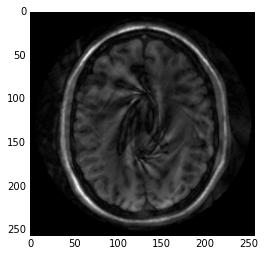

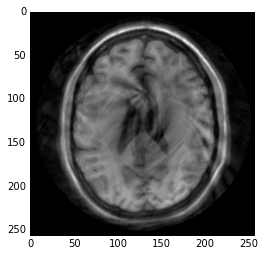

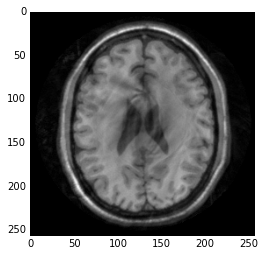

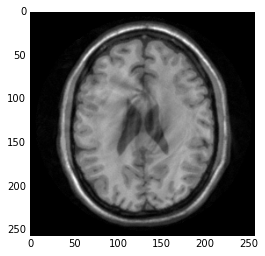

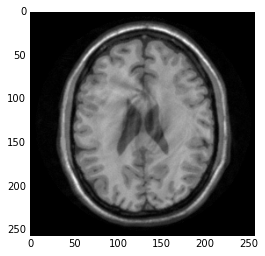

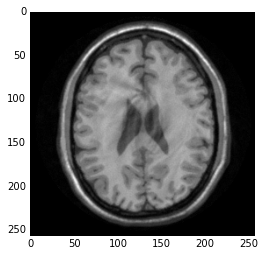

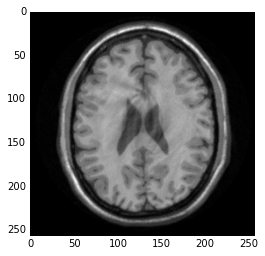

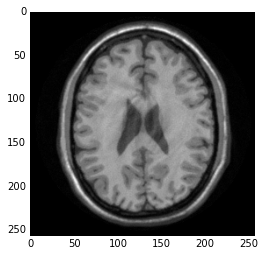

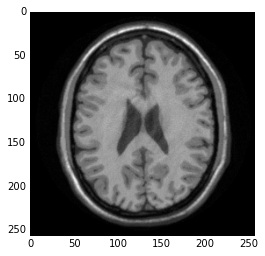

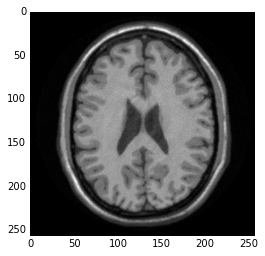

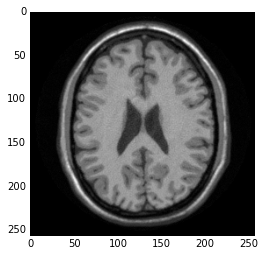

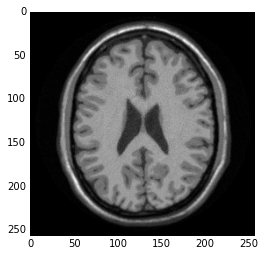

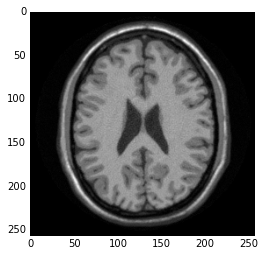

In [6]:
At  = lambda v: E_transp(v)
AtA = lambda v: E_transp( E_forward(v) )
coildata = data_spiral * sqrt(w_spiral)

# AtA*x = At*b
b = At(coildata)
x = zeros_like(smaps[:,:,0])
r = b - AtA(x)
p = copy(r)

np.save("b.npy", b)
np.save("x.npy", x)

for i in range(13):
    rsold = dotf(r, r)
    AtAp = AtA(p)
    alpha = rsold / dotf(p, AtAp)
    x += alpha * p
    r -= alpha * AtAp   
    rsnew = dotf(r,r)
    beta = rsnew / rsold
    p = r + beta * p
    
    imshow(abs(x), cmap='gray'); show()